# Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.analysis_helpers import *

## Choose features of the data to analyse
- Drop or select specifics conditions
- Differentiate between interviwer & participant

In [4]:
directory = '../interviews_corrected/5_conditions/**/' 

df = load_and_combine_csv(directory)
df = standardize_data(df)
df = calculate_word_char_counts(df)

df.to_csv("combined_data.csv", index=False)

Found 82 CSV files.
Standardized speaker labels.
Normalized text in 'Content' column.
Calculated 'Word_Count' and 'Character_Count' for each response.


In [5]:
print(df["Condition"].unique())
# Drop the rows equal to 0 for the column condition
df = df[df["Condition"] != 0]
print(df["Condition"].unique())

[1 'C' 'I' 0]
[1 'C' 'I']


In [6]:
# If only want to focus on participant speaker
df_participant = df[df["Speaker"] == "Participant"]
df_interviewer = df[df["Speaker"] == "Interviewer"]

### Word Count

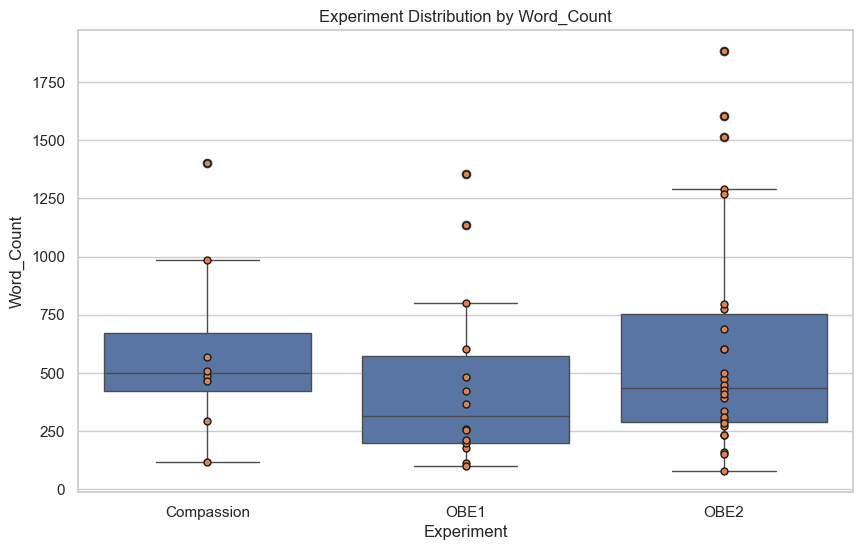

In [7]:
stripplot(aggregate_counts(df_participant,["Experiment","Id"]), 'Experiment', 'Word_Count')

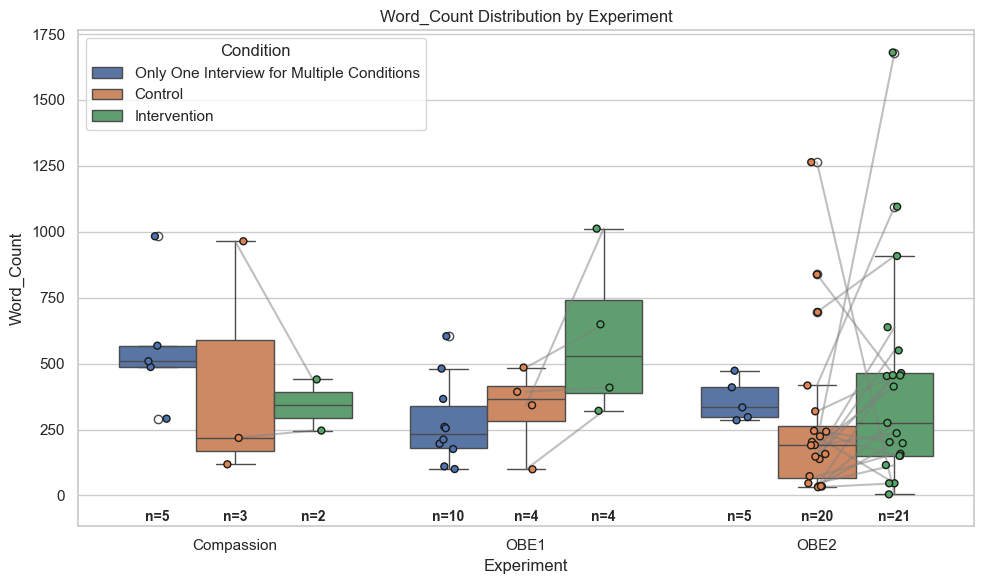

In [ ]:
# Group by Id instead of File Name because the same participant can have the same condition in different interviews
stripplot_with_counts(aggregate_counts(df_participant, ['Experiment', "Id", "Condition"]), 'Experiment', 'Word_Count', 
                      hue_column='Condition', id_column="Id", legend_labels=["Only One Interview for Multiple Conditions","Control","Intervention"])#,file_name="stripplot_word_count_id.png")

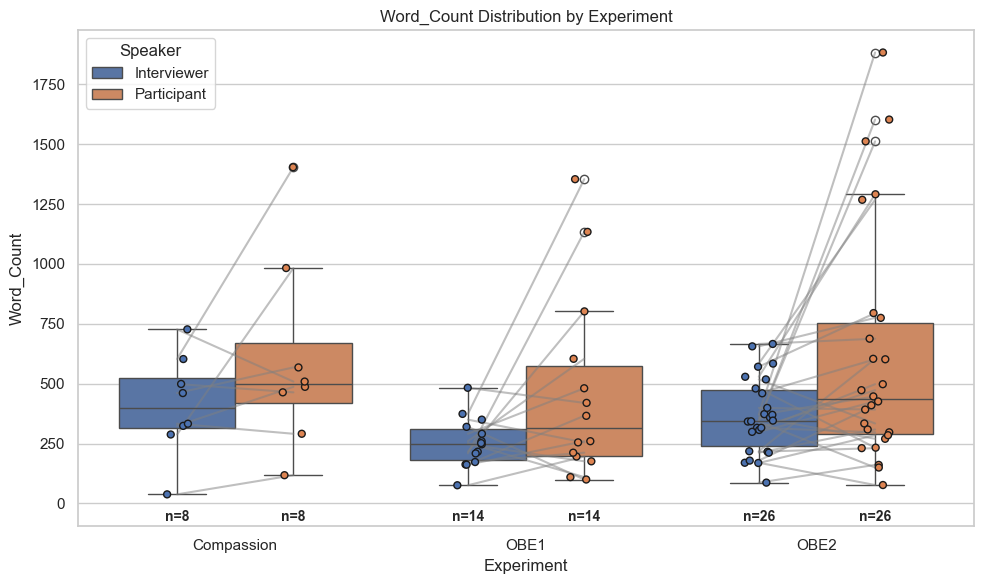

In [114]:
stripplot_with_counts(aggregate_counts(df, ['Experiment', "Id", 'Speaker']), 'Experiment', 'Word_Count', hue_column='Speaker', id_column="Id")

### Frequency & Unique Words

In [115]:
extra_words_to_exclude = ["yeah", "like", "okay" ,"really", "it", "yes","could","kind","bit","think","that's"] 

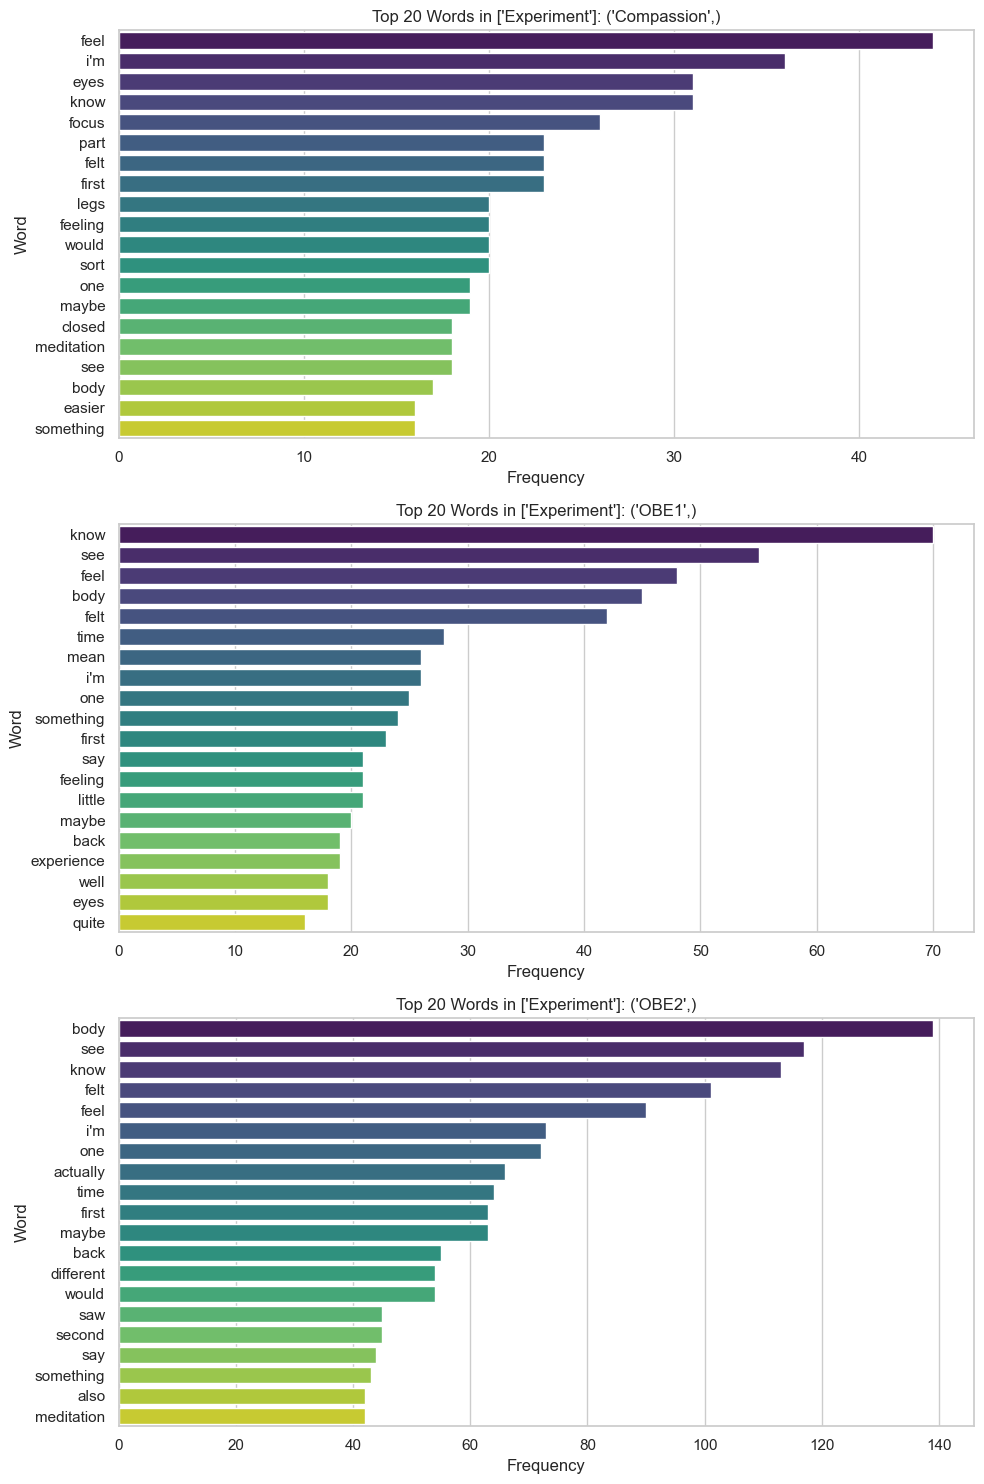

In [116]:
word_frequency_plot(df_participant, groupby_column=["Experiment"], extra_stopwords=extra_words_to_exclude)

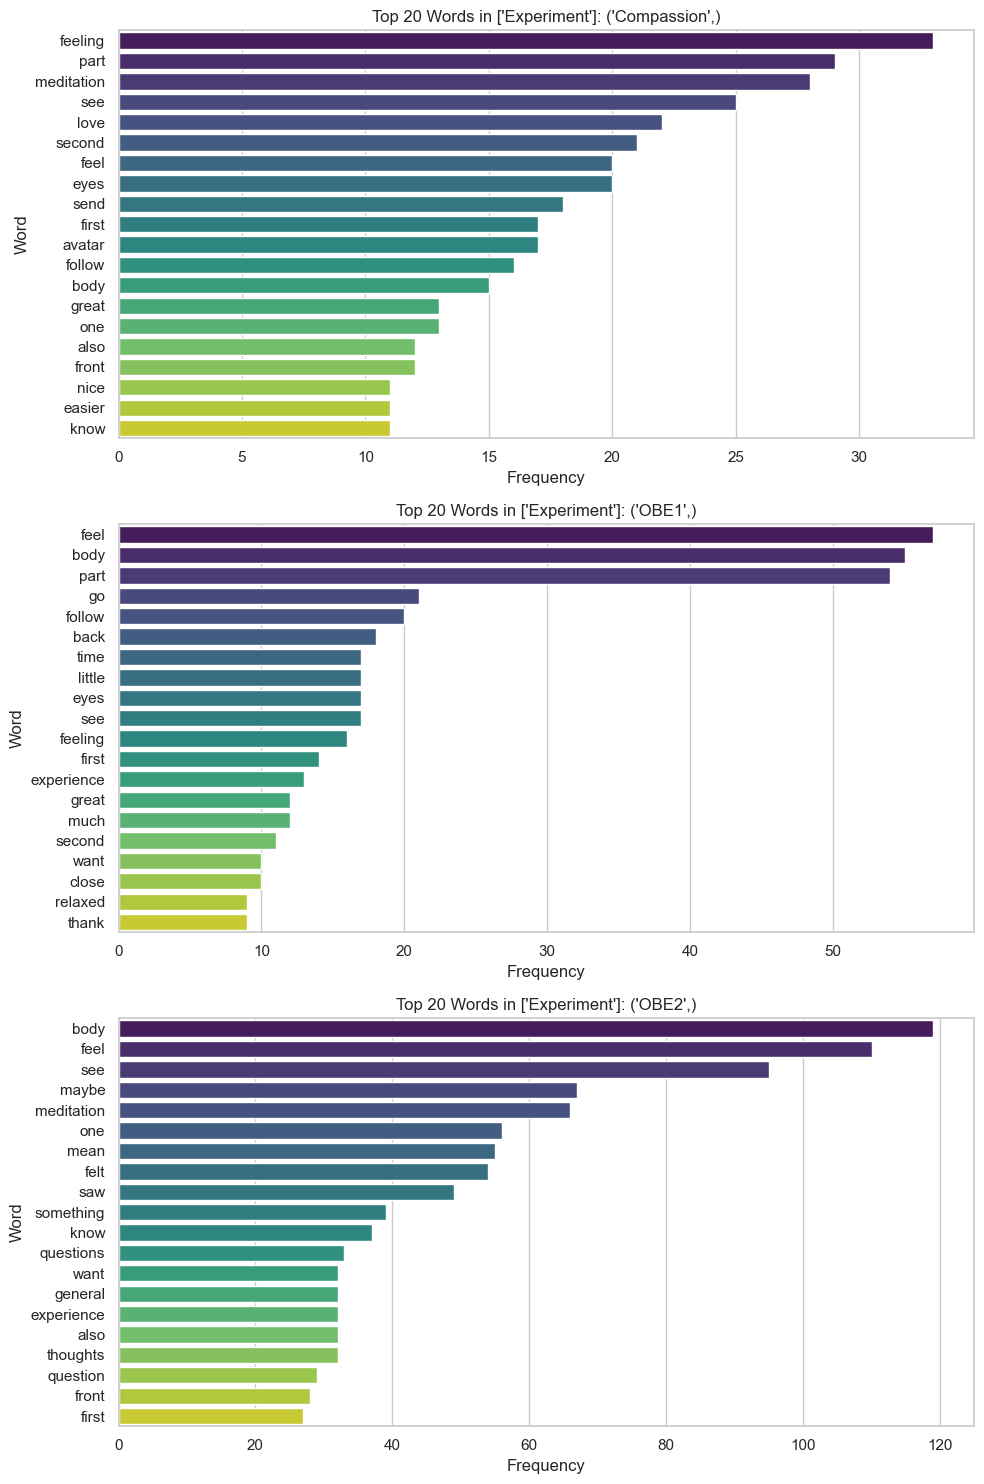

In [117]:
word_frequency_plot(df_interviewer, groupby_column=["Experiment"], extra_stopwords=extra_words_to_exclude)

In [118]:
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']

unique_words_df = count_unique_words(df, groupby_columns=['Experiment', 'Condition'], extra_stopwords=extra_words_to_exclude)
unique_words_df = unique_words_df.sort_values(by='Participant_Count', ascending=False)
unique_words_df.to_csv("unique_words.csv", index=False)

unique_words_df_participant = count_unique_words(df_participant, groupby_columns=['Experiment', 'Condition'], omit_stop_words=True, extra_stopwords=extra_words_to_exclude)
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
unique_words_df_participant.to_csv("unique_words_participant.csv", index=False)

unique_words_df_interviewer = count_unique_words(df_interviewer, groupby_columns=['Experiment', 'Condition'], omit_stop_words=True, extra_stopwords=extra_words_to_exclude)
unique_words_df_interviewer = unique_words_df_interviewer.sort_values(by='Participant_Count', ascending=False)
unique_words_df_interviewer.to_csv("unique_words_interviewer.csv", index=False)

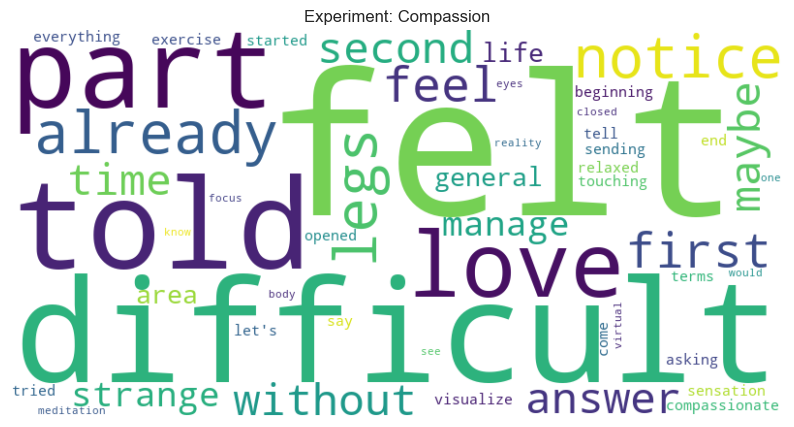

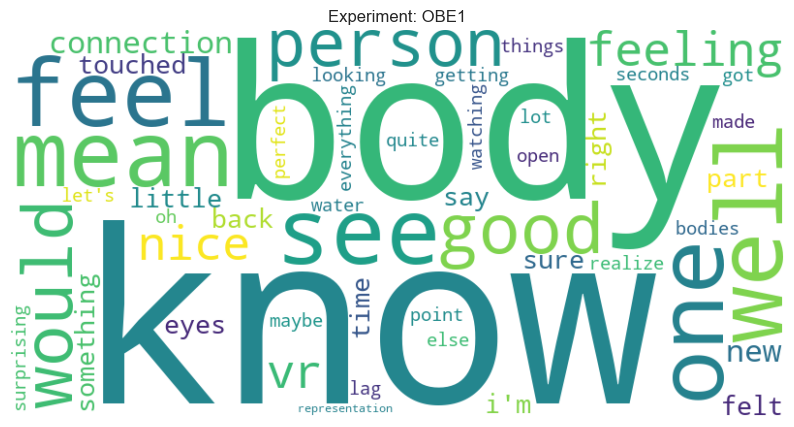

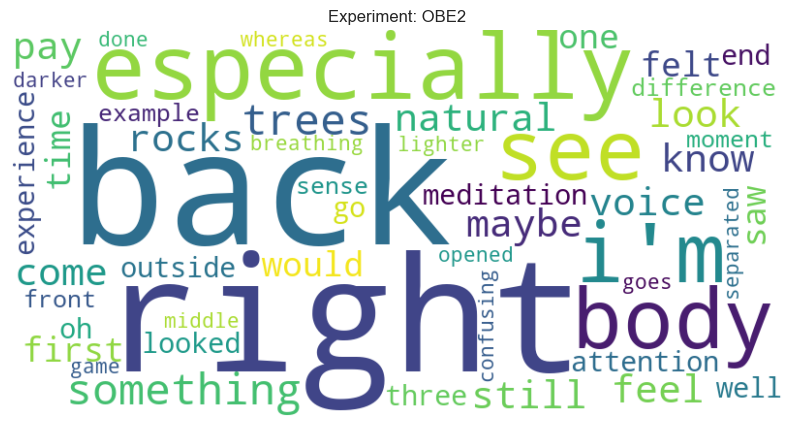

In [119]:
generate_word_clouds(unique_words_df_participant, groupby_columns=['Experiment'])

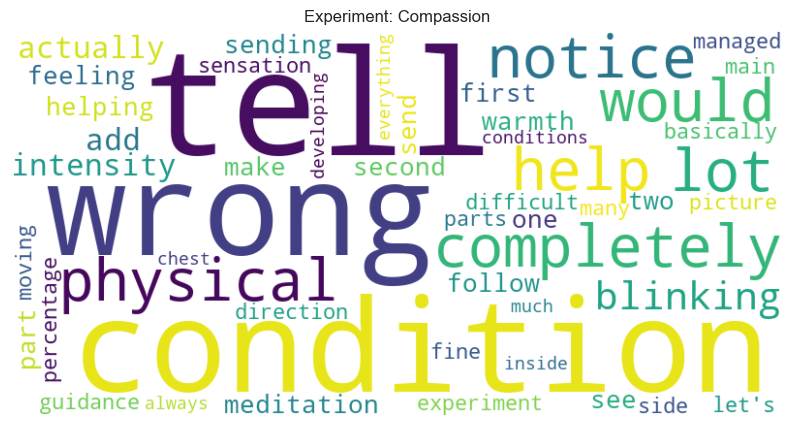

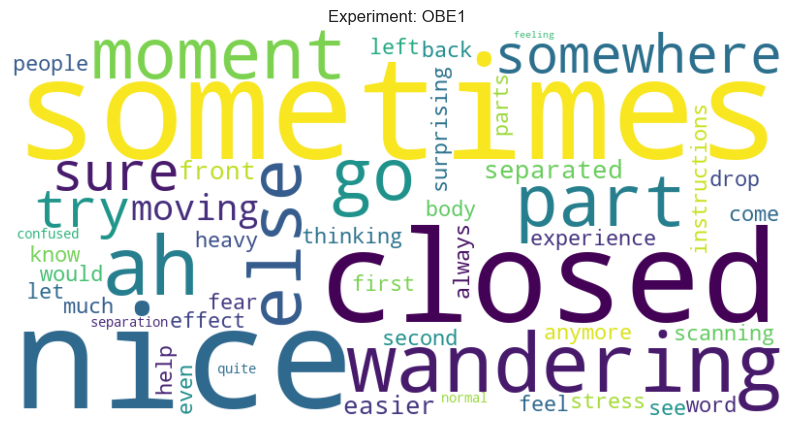

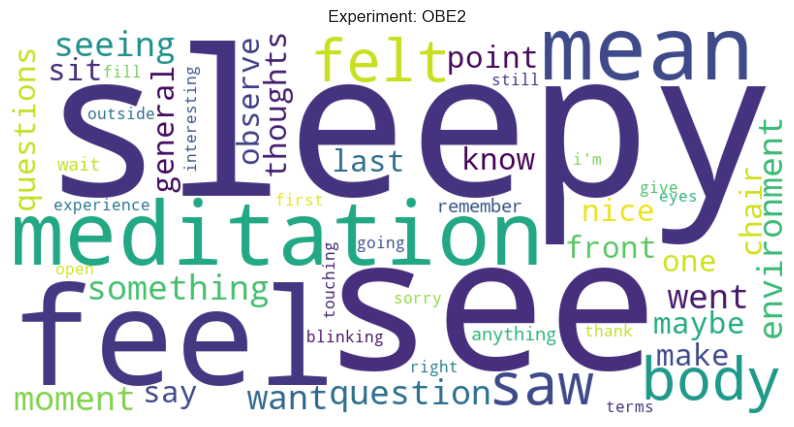

In [120]:
generate_word_clouds(unique_words_df_interviewer, groupby_columns=['Experiment'])

### Cluster 1.0

In [122]:
# Preprocess text
df_participant.loc[:, 'preprocessed_content'] = df_participant['Content'].apply(preprocess_text)

# Group data by Experiment and Participant
grouped_df = df_participant.groupby(['Experiment', 'Id'])['preprocessed_content'].apply(' '.join).reset_index()

# Perform clustering with both methods
clustered_dfs_tfidf, tfidf_matrices = cluster_tfidf_kmeans(grouped_df, 2)
clustered_dfs_bert, bert_matrices = cluster_bert_kmeans(grouped_df, 2)

C:\Users\david\AppData\Local\Temp\ipykernel_22128\2470399989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_participant.loc[:, 'preprocessed_content'] = df_participant['Content'].apply(preprocess_text)


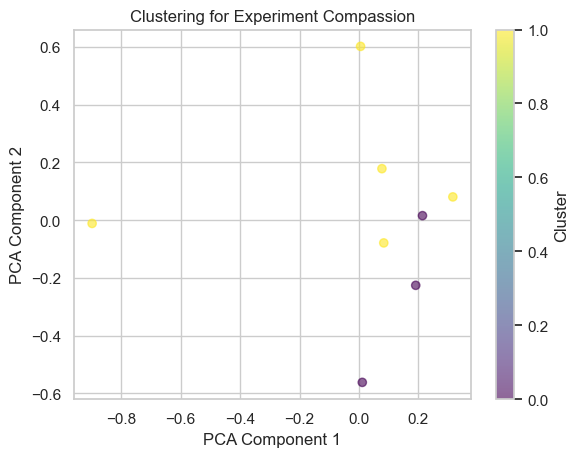

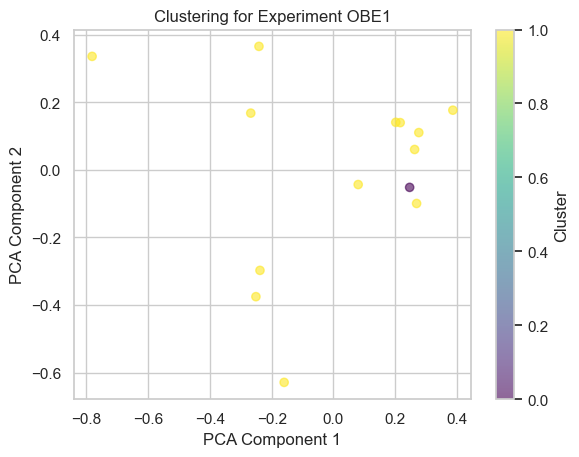

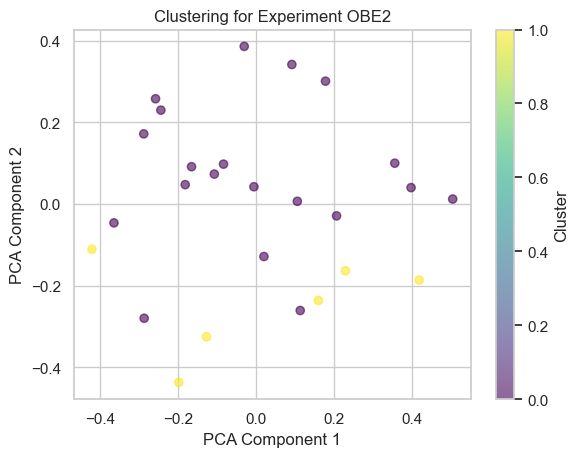

In [123]:
visualize_clusters(clustered_dfs_tfidf)

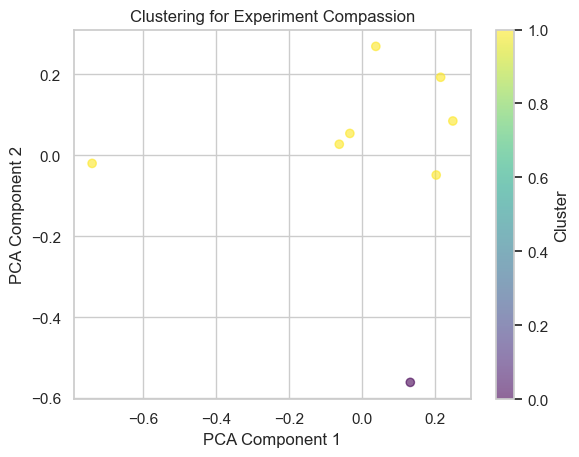

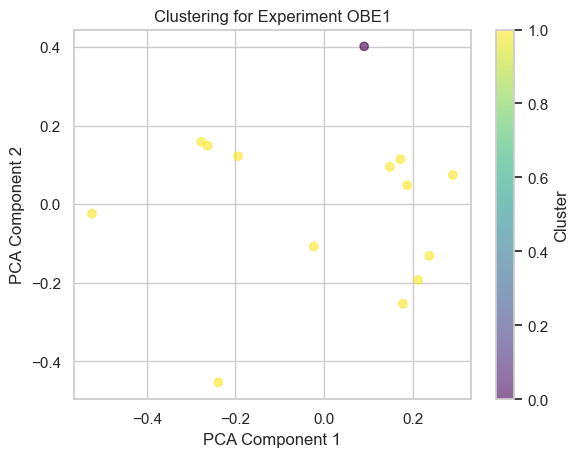

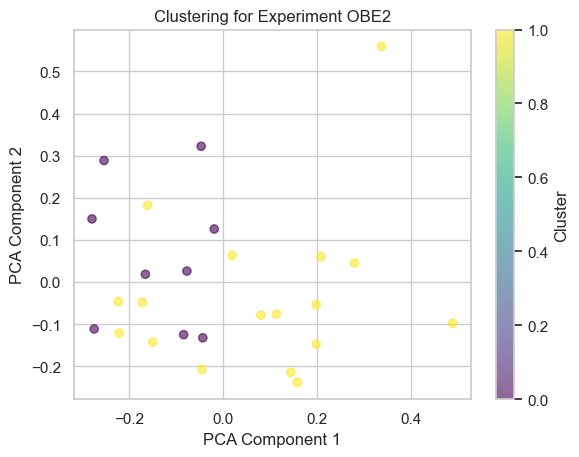

In [124]:
visualize_clusters(clustered_dfs_bert)

In [125]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def calculate_cluster_metrics(X, labels):
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    return silhouette, davies_bouldin

def get_top_terms_tfidf(df, n_clusters=2, top_n=10):
    vectorizer = TfidfVectorizer(max_features=1000)
    X_tfidf = vectorizer.fit_transform(df['preprocessed_content'])
    terms = vectorizer.get_feature_names_out()
    cluster_terms = {}

    # Run clustering to get cluster labels
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_tfidf)

    # Extract top terms for each cluster
    for cluster in range(n_clusters):
        indices = df[df['cluster'] == cluster].index
        cluster_tfidf = X_tfidf[indices].mean(axis=0).A1
        top_terms = terms[cluster_tfidf.argsort()[-top_n:]].tolist()
        cluster_terms[cluster] = top_terms
    
    return cluster_terms

from sklearn.metrics import adjusted_rand_score

def calculate_ari(labels_1, labels_2):
    return adjusted_rand_score(labels_1, labels_2)

In [126]:
# Calculate cluster quality metrics for TF-IDF
for i, (experiment_df, X_tfidf) in enumerate(zip(clustered_dfs_tfidf, tfidf_matrices)):
    silhouette, davies_bouldin = calculate_cluster_metrics(X_tfidf, experiment_df[0]['cluster'])
    experiment_name = experiment_df[0]["Experiment"].unique()[0]
    print(f"TF-IDF Clustering for Experiment {experiment_name} - Silhouette: {silhouette}, Davies-Bouldin: {davies_bouldin}")

# Get top terms for each TF-IDF cluster
top_terms = get_top_terms_tfidf(grouped_df, n_clusters=2, top_n=10)
print("Top terms for each TF-IDF cluster:", top_terms)


TF-IDF Clustering for Experiment Compassion - Silhouette: 0.0015732849063879676, Davies-Bouldin: 2.260212574221618
TF-IDF Clustering for Experiment OBE1 - Silhouette: 0.02899624291164298, Davies-Bouldin: 0.8704214492434089
TF-IDF Clustering for Experiment OBE2 - Silhouette: 0.019708167824322793, Davies-Bouldin: 3.5707679953735845
Top terms for each TF-IDF cluster: {0: ['one', 'see', 'feel', 'know', 'think', 'really', 'body', 'felt', 'yeah', 'like'], 1: ['feel', 'body', 'dont', 'see', 'know', 'think', 'time', 'like', 'yes', 'yeah']}


In [127]:
for i, (experiment_df, X_embeddings) in enumerate(zip(clustered_dfs_bert, bert_matrices)):
    silhouette, davies_bouldin = calculate_cluster_metrics(X_embeddings, experiment_df[0]['cluster'])
    experiment_name = experiment_df[0]["Experiment"].unique()[0]
    print(f"BERT Clustering for Experiment {experiment_name} - Silhouette: {silhouette}, Davies-Bouldin: {davies_bouldin}")

BERT Clustering for Experiment Compassion - Silhouette: 0.06600475311279297, Davies-Bouldin: 0.7527253869875876
BERT Clustering for Experiment OBE1 - Silhouette: 0.003353537991642952, Davies-Bouldin: 0.9083037268769777
BERT Clustering for Experiment OBE2 - Silhouette: 0.01948496326804161, Davies-Bouldin: 3.3498074563971674


In [128]:
# Calculate Adjusted Rand Index between TF-IDF and BERT clusters
tfidf_labels = [experiment_df[0]['cluster'].values for experiment_df in clustered_dfs_tfidf]
bert_labels = [experiment_df[0]['cluster'].values for experiment_df in clustered_dfs_bert]

for i, (tfidf, bert) in enumerate(zip(tfidf_labels, bert_labels)):
    ari = calculate_ari(tfidf, bert)
    print(f"Adjusted Rand Index for Experiment {i+1} between TF-IDF and BERT clusters: {ari:.2f}")

Adjusted Rand Index for Experiment 1 between TF-IDF and BERT clusters: 0.17
Adjusted Rand Index for Experiment 2 between TF-IDF and BERT clusters: 1.00
Adjusted Rand Index for Experiment 3 between TF-IDF and BERT clusters: -0.03


In [129]:
# Get representative sentences for BERT clusters
for i, (experiment_df, X_embeddings) in enumerate(zip(clustered_dfs_bert, bert_matrices)):
    experiment_name = experiment_df[0]["Experiment"].unique()[0]
    bert_representatives = get_representative_sentences(experiment_df[0], X_embeddings, n_clusters=2, top_n=5)
    print(f"Representative sentences for BERT clusters in {experiment_name}:")
    for cluster, sentences in bert_representatives.items():
        print(f"Cluster {cluster}:")
        for sentence in sentences:
            print(f"- {sentence}")

Representative sentences for BERT clusters in Compassion:
Cluster 0:
- eye closed whole time find lot hard lot harder stay track guess stay focused minute step meditation quite chaotic brain guess eye closed compared eye open one found drifting lot lot easier drift sort go way im supposed like ignore thought make sense yeah eye open lot easier focus attention yeah definitely second part could still follow effort spent making sure following rather first one open looking body lot easier sort pinpoint attention distracted much still able go follow step could get distracted lot easier still still sort realm like still quite relaxing still easy follow still didnt like induce sense like ease thing like diminished would spend time going wait im track ive got get back track start instead focusing like inducing feeling wanting actually focus time spent going oh im thinking something else got come back yeah still partially successful sense still able relax go step instructing try induce feeling 

In [130]:
from umap import UMAP
import matplotlib.pyplot as plt

def visualize_clusters_umap(embeddings, labels):
    umap = UMAP(n_components=2, random_state=42)
    reduced_embeddings = umap.fit_transform(embeddings)
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(label='Cluster')
    plt.title("BERT Embedding Clusters with UMAP")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

# Example usage after BERT clustering
kmeans_bert = KMeans(n_clusters=2, random_state=42).fit(bert_matrices[0])
visualize_clusters_umap(bert_matrices[0], kmeans_bert.labels_)


ImportError: cannot import name 'UMAP' from 'umap' (c:\Users\david\anaconda3\envs\basic\lib\site-packages\umap\__init__.py)

### Cluster 2.0

In [135]:
# Preprocess text with the updated function
df_participant['preprocessed_content'] = df_participant['Content'].apply(preprocess_text)

# Group data by Experiment and Participant
grouped_df = df_participant.groupby(['Experiment', 'Id'])['preprocessed_content'].apply(' '.join).reset_index()

# Load the BERT model once
model = SentenceTransformer('all-MiniLM-L6-v2')

C:\Users\david\AppData\Local\Temp\ipykernel_22128\908853607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_participant['preprocessed_content'] = df_participant['Content'].apply(preprocess_text)


In [ ]:
# Determine optimal number of clusters for TF-IDF
X_tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 3)).fit_transform(grouped_df['preprocessed_content']).toarray()
find_optimal_clusters(X_tfidf, max_k=10)

In [ ]:
# Based on the plots, set optimal_k
optimal_k = 3

# Perform TF-IDF clustering
clustered_dfs_tfidf, tfidf_matrices = cluster_tfidf_kmeans(grouped_df, n_clusters=optimal_k)

# Visualize clusters with PCA
visualize_clusters(clustered_dfs_tfidf)

# Create word clouds for TF-IDF clusters
for experiment_df, _ in clustered_dfs_tfidf:
    create_wordclouds(experiment_df)

In [ ]:
# Repeat for BERT embeddings
X_embeddings = model.encode(grouped_df['preprocessed_content'].tolist())
find_optimal_clusters(X_embeddings, max_k=10)

In [ ]:
# Based on the plots, set optimal_k
optimal_k_bert = 3

clustered_dfs_bert, bert_matrices = cluster_bert_kmeans(grouped_df, model, n_clusters=optimal_k_bert)

# Visualize BERT clusters with t-SNE
visualize_clusters_tsne(clustered_dfs_bert, bert_matrices)

# Create word clouds for BERT clusters
for experiment_df, _ in clustered_dfs_bert:
    create_wordclouds(experiment_df)